In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
import tldextract
from urllib.parse import urlparse

import warnings
warnings.filterwarnings("ignore")

#import pickle
#import joblib

In [3]:
df = pd.read_csv('phishing_site_urls.csv')
df.columns = [x.lower() for x in df.columns]
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

In [4]:
def feature_creation(x):
    features = {}
    
    dom_ngram = {}
    subdom_ngram = {}

    dom = tldextract.extract(x).domain
    subdom = tldextract.extract(x).subdomain
    n  = 2
    for index in range(0, len(dom), n):
        dom_ngram[dom[index : index + n]] = 1
    features.update(dom_ngram)

    elements = [
    {"item": "domain", "data": tldextract.extract(x).domain},
    {"item": "subdomain", "data": tldextract.extract(x).subdomain},
    {"item": "suffix", "data": tldextract.extract(x).suffix},
    {"item": "path", "data": urlparse(x).path},
    {"item": "params", "data": urlparse(x).params},
    {"item": "query", "data": urlparse(x).query},
    {"item": "fragment", "data": urlparse(x).fragment}]
    
    for i in elements:
        features[f'len_{i["item"]}'] = len(i["data"])
        for sc in '!@#$%-_=~?+;':
            features[f'len_{sc}_in_{i["item"]}'] = i["data"].count(sc)
        if i["item"] in ['domain','path','subdomain']:
            features[f'len_digits_in_{i["item"]}'] = len(re.findall('[0-9]',x))
            features[f'len_alphas_in_{i["item"]}'] = len(re.findall('[a-z]',x.lower()))
    return features

In [5]:
y_elements = []
X_elements = []

for url, label in zip(df['url'], df['Y']):
    f = feature_creation(url)
    y_elements.append(label)
    X_elements.append(f)

In [6]:
pre_processor = DictVectorizer(sparse=True)
X = pre_processor.fit_transform(X_elements)
X = csr_matrix(X)
X = X.tocsr()
y = np.array(y_elements).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
%%time

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, y_train)
pred = lg.predict(X_test)



CPU times: user 14.5 s, sys: 56.2 ms, total: 14.6 s
Wall time: 14.6 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [8]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test,lg.predict(X_test)))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.80      0.94      0.87     78670
           1       0.75      0.42      0.54     31200

    accuracy                           0.80    109870
   macro avg       0.78      0.68      0.70    109870
weighted avg       0.79      0.80      0.77    109870




CONFUSION MATRIX


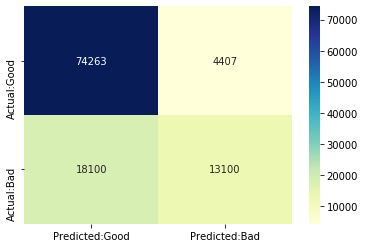

In [9]:
con_mat = pd.DataFrame(confusion_matrix(y_test,lg.predict(X_test)),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")